In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pylab as pl
from vqr.vector_2d import vector_quantile, separable_quantile

d = 2
T = 50

heart = False

if heart:
    image = 1 - pl.imread('../data/heart.png')[:, :, 2]
    image = image[::3, ::3]
    image = (image/np.sum(image))
    idces = image.nonzero()
    Y = np.zeros([len(idces[0]), 2])
    Y[:, 0] = idces[0]/idces[0].max()
    Y[:, 1] = idces[1]/idces[1].max()
else:
    N = 1000
    rho = 0.6
    Y = np.random.multivariate_normal(mean=[0, 0], cov=[[1, rho], [rho, 1]], size=(N,))

In [2]:

u = 1 / T * (np.arange(0, T) + 1)
U1, U2 = np.meshgrid(*([u,]*d)) # not handling d>2
U = np.stack([U1.reshape(-1), U2.reshape(-1)], axis=1)

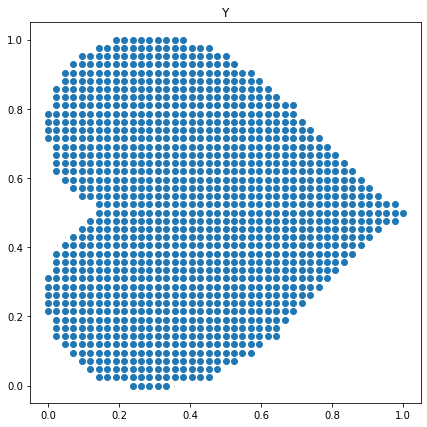

In [3]:
fig = plt.figure(figsize=(7,7))
plt.scatter(Y[:, 0], Y[:, 1])
_ = plt.title("Y")

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 24 07:20:40 PM: Your problem has 3067500 variables, 3 constraints, and 0 parameters.
(CVXPY) Jul 24 07:20:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 24 07:20:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 24 07:20:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 24 07:20:40 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 24 07:20:40 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr ->

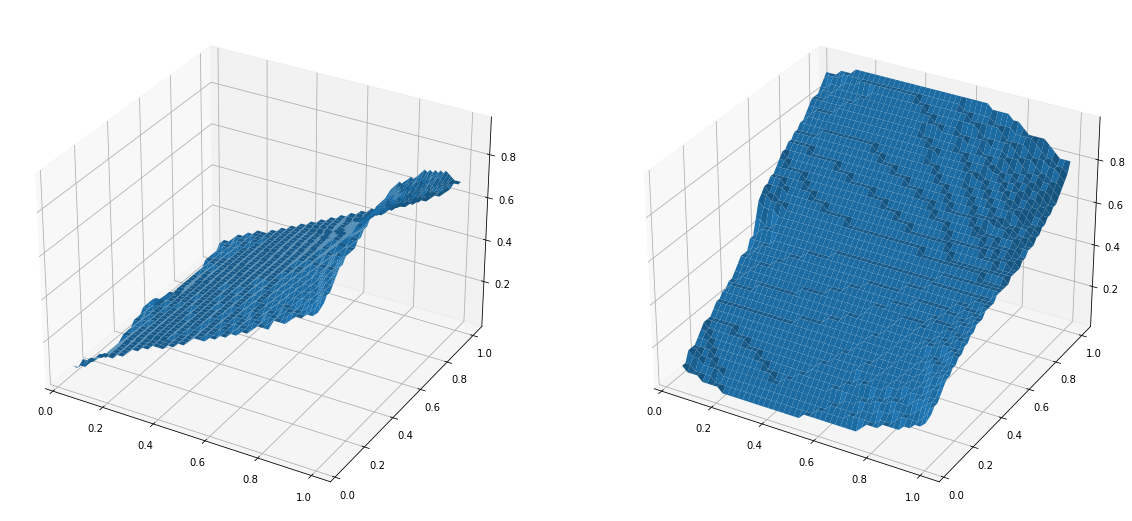

In [4]:
Q1, Q2 = vector_quantile(Y, U)
Q1 = Q1.reshape([T, T])
Q2 = Q2.reshape([T, T])

fig, ax = plt.subplots(1, d, figsize=(20, 10), subplot_kw={"projection": "3d"})
ax[0].plot_surface(U1[1:, 1:], U2[1:, 1:], Q1[1:, 1:])
ax[1].plot_surface(U1[1:, 1:], U2[1:, 1:], Q2[1:, 1:])

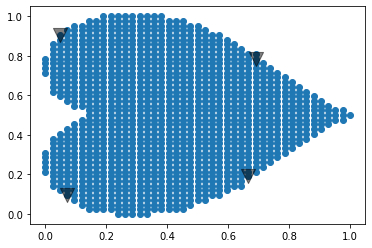

In [5]:
q_10_90 = [Q1[ 1, -2], Q2[ 1, -2]]
q_90_90 = [Q1[-2, -2], Q2[-2, -2]]
q_90_10 = [Q1[-2,  1], Q2[-2,  1]]
q_10_10 = [Q1[ 1,  1], Q2[ 1,  1]]

plt.scatter(Y[:, 0], Y[:, 1])
plt.scatter(q_10_90[0], q_10_90[1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(q_90_90[0], q_90_90[1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(q_90_10[0], q_90_10[1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(q_10_10[0], q_10_10[1], alpha=.5, color='k', s=200, marker='v')

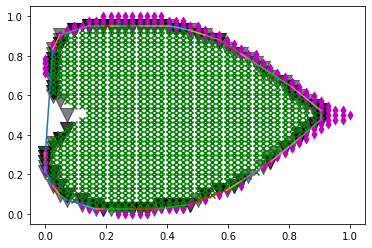

In [6]:
from scipy.spatial import ConvexHull

surface = np.array([[*Q1[1:-2, -2], *Q1[1, 1:-2], *Q1[1:-2, 1], *Q1[-2, 1:-2]],
                    [*Q2[1:-2, -2], *Q2[1, 1:-2], *Q2[1:-2, 1], *Q2[-2, 1:-2]]]).T

def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)

selected_Y = surface
hull = ConvexHull(selected_Y)
for simplex in hull.simplices:
    plt.plot(selected_Y[simplex, 0], selected_Y[simplex, 1])
    
plt.scatter(*selected_Y.T, alpha=.5, color='k', s=200, marker='v')

coverage = []
for p in Y:
    point_is_in_hull = point_in_hull(p, hull)
    coverage.append(point_is_in_hull)
    marker = 'x' if point_is_in_hull else 'd'
    color = 'g' if point_is_in_hull else 'm'
    plt.scatter(p[0], p[1], marker=marker, color=color)

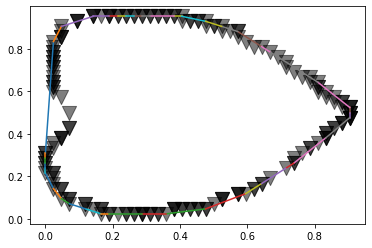

In [7]:
plt.scatter(*selected_Y.T, alpha=.5, color='k', s=200, marker='v')
for simplex in hull.simplices:
    plt.plot(selected_Y[simplex, 0], selected_Y[simplex, 1])

In [8]:
coverage_final = (sum(coverage)/len(coverage))*100

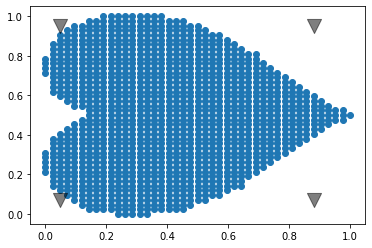

In [9]:
Q1_sep, Q2_sep = separable_quantile(Y, U)

q_10_90 = [Q1_sep[1] , Q2_sep[-2]]
q_90_90 = [Q1_sep[-2], Q2_sep[-2]]
q_90_10 = [Q1_sep[-2], Q2_sep[ 1]]
q_10_10 = [Q1_sep[ 1], Q2_sep[ 1]]

plt.scatter(Y[:, 0], Y[:, 1])
plt.scatter(q_10_90[0], q_10_90[1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(q_90_90[0], q_90_90[1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(q_90_10[0], q_90_10[1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(q_10_10[0], q_10_10[1], alpha=.5, color='k', s=200, marker='v')

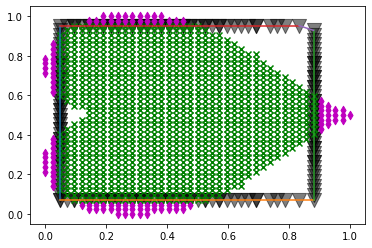

In [10]:
from scipy.spatial import ConvexHull

surface_sep = np.array([[*Q1_sep[1:-2],
                     *Q1_sep[1:-2], 
                     *[Q1_sep[ 1]]*len(Q2_sep[1:-2]),
                     *[Q1_sep[-2]]*len(Q2_sep[1:-2]),
                    ],
                     
                    [*[Q2_sep[-2]]*len(Q1_sep[1:-2]),
                     *[Q2_sep[1]]*len(Q1_sep[1:-2]), 
                     *Q2_sep[1:-2], 
                     *Q2_sep[1:-2]
                    ]
                    ]).T

def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)

selected_Y = surface_sep
hull = ConvexHull(selected_Y)
for simplex in hull.simplices:
    plt.plot(selected_Y[simplex, 0], selected_Y[simplex, 1])
    
plt.scatter(*selected_Y.T, alpha=.5, color='k', s=200, marker='v')

coverage_sep = []
for p in Y:
    point_is_in_hull = point_in_hull(p, hull)
    coverage_sep.append(point_is_in_hull)
    marker = 'x' if point_is_in_hull else 'd'
    color = 'g' if point_is_in_hull else 'm'
    plt.scatter(p[0], p[1], marker=marker, color=color)

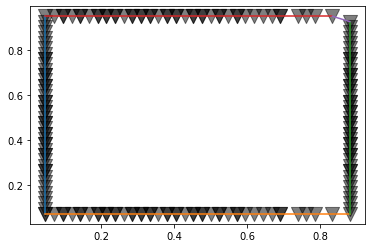

In [11]:
plt.scatter(*selected_Y.T, alpha=.5, color='k', s=200, marker='v')
for simplex in hull.simplices:
    plt.plot(selected_Y[simplex, 0], selected_Y[simplex, 1])

In [12]:
coverage_sep_final = (sum(coverage_sep)/len(coverage_sep))*100

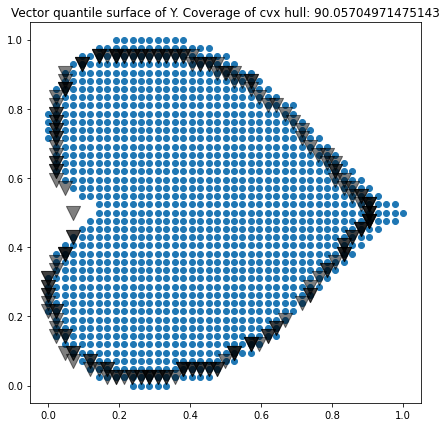

In [13]:
fig = plt.figure(figsize=(7, 7))
plt.scatter(Y[:, 0], Y[:, 1])
plt.scatter(Q1[1:-2, -2], Q2[1:-2, -2], alpha=.5, color='k', s=200, marker='v')
plt.scatter(Q1[1,  1:-2], Q2[1, 1: -2], alpha=.5, color='k', s=200, marker='v')
plt.scatter(Q1[1:-2,  1], Q2[1:-2,  1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(Q1[-2, 1:-2], Q2[-2, 1:-2], alpha=.5, color='k', s=200, marker='v')

_ = plt.title(f"Vector quantile surface of Y. Coverage of cvx hull: {coverage_final}")

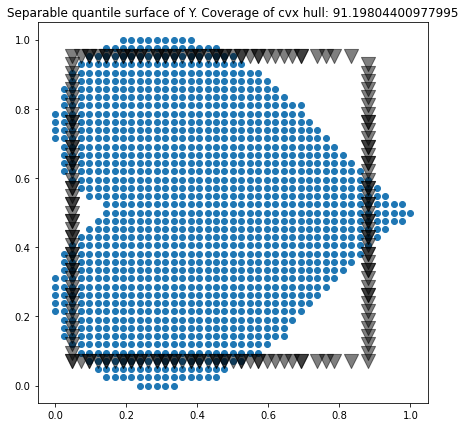

In [14]:
fig = plt.figure(figsize=(7, 7))

plt.scatter(Y[:, 0], Y[:, 1])
plt.scatter(Q1_sep[1:-2], [Q2_sep[-2]]*len(Q1_sep[1:-2]), alpha=.5, color='k', s=200, marker='v')
plt.scatter(Q1_sep[1:-2], [Q2_sep[1]]*len(Q1_sep[1:-2]), alpha=.5, color='k', s=200, marker='v')
plt.scatter([Q1_sep[ 1]]*len(Q2_sep[1:-2]), Q2_sep[1:-2], alpha=.5, color='k', s=200, marker='v')
plt.scatter([Q1_sep[-2]]*len(Q2_sep[1:-2]), Q2_sep[1:-2], alpha=.5, color='k', s=200, marker='v')
_ = plt.title(f"Separable quantile surface of Y. Coverage of cvx hull: {coverage_sep_final}")